## Part a: Aggregate Planning

### Import all libraries needed

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import docplex
from docplex.mp.model import Model

### Create a model instance

In [2]:
model = Model(name = 'optimal_production_quantity')

### Define sets and parameters

In [3]:
# Define indices and parameters
periods = [1, 2, 3, 4, 5, 6]

products = [1, 2, 3]

# Demand of each product in each period
demand = pd.DataFrame([[130, 100, 50, 160, 150, 90], [80, 120, 210, 150, 90, 110], [60, 45, 80, 90, 70, 50]], index=products, columns=periods)

# Required personnel capacity of each product
required_personnel = {1:0.5, 2:1, 3:0.8}

# Required technical capacity of each product
required_technical = {1:1, 2:0.5, 3:0.8}

# Maximum personnel capacity in each period
max_personnel_cap = {1:250, 2:250, 3:250, 4:250, 5:250, 6:250}

# Maximum technical capacity in each period
max_technical_cap = {1:300, 2:300, 3:300, 4:300, 5:300, 6:300}

# Maximum overtime in each period
max_overtime = {1:100, 2:100, 3:100, 4:100, 5:100, 6:100}

# Inventory cost of each product (per unit per period)
c_int = {1:800, 2:450, 3:600}

# Overtime cost (per unit of overtime)
c_overtime = 1000

# Initial inventory of each product
L0 = {1:20, 2:0, 3:0}

### Define decision variables

In [4]:
prod_quant = model.integer_var_matrix(products, periods, name='Production quantity')

int_level = model.integer_var_matrix(products, periods, name='Inventory level')

ovt_cap = model.integer_var_dict(periods, name='Used additional personnel capacity')

### Define constraints

In [5]:
# Inventory level equation
for p in products:
    model.add_constraint(int_level[p, 1] == L0[p] + prod_quant[p, 1] - demand.loc[p, 1])

for t in range(2, len(periods)+1):
    for p in products:
        model.add_constraint(int_level[p, t] == int_level[p, t-1] + prod_quant[p, t] - demand.loc[p, t])
        

# Used personnel capacity constraint
for t in periods:
    model.add_constraint(model.sum(required_personnel[p] * prod_quant[p, t] for p in products) <= max_personnel_cap[t] + ovt_cap[t])


# Used technical capacity constraint
for t in periods:
    model.add_constraint(model.sum(required_technical[p] * prod_quant[p, t] for p in products) <= max_technical_cap[t])


# Used overtime in each period
for t in periods:
    model.add_constraint(ovt_cap[t] <= max_overtime[t])

# Non-negative
for p in products:
    for t in periods:
        model.add_constraint(prod_quant[p, t] >= 0)

for p in products:
    for t in periods:
        model.add_constraint(int_level[p, t] >= 0)

for t in periods:
    model.add_constraint(ovt_cap[t] >= 0)

### Define linear expressions

In [6]:
inventory_cost = []
for t in periods:
    for p in products:
        c_int_p_per_t = c_int[p] * int_level[p, t]
        inventory_cost.append(c_int_p_per_t)


overtime_cost = model.sum(c_overtime * ovt_cap[t] for t in periods)

production_cost = model.sum(model.sum(inventory_cost) + overtime_cost)

### Define objective function

In [7]:
model.minimize(production_cost)

### Solve model

In [8]:
solution = model.solve()

### Postprocessing

In [9]:
solution.objective_value

81000.0

In [10]:
print(solution)

solution for: optimal_production_quantity
objective: 81000
status: OPTIMAL_SOLUTION(2)
Production quantity_1_1=110
Production quantity_1_2=100
Production quantity_1_3=50
Production quantity_1_4=160
Production quantity_1_5=150
Production quantity_1_6=90
Production quantity_2_1=95
Production quantity_2_2=164
Production quantity_2_3=157
Production quantity_2_4=144
Production quantity_2_5=90
Production quantity_2_6=110
Production quantity_3_1=60
Production quantity_3_2=45
Production quantity_3_3=85
Production quantity_3_4=85
Production quantity_3_5=70
Production quantity_3_6=50
Inventory level_2_1=15
Inventory level_2_2=59
Inventory level_2_3=6
Inventory level_3_3=5
Used additional personnel capacity_4=42



In [11]:
model.report()

* model optimal_production_quantity solved with objective = 81000.000


In [12]:
model.print_information()

Model: optimal_production_quantity
 - number of variables: 42
   - binary=0, integer=42, continuous=0
 - number of constraints: 78
   - linear=78
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP


In [16]:
print('The objective value is', model.objective_value)
for t in periods:
    for p in products:
        print(f'Production quantity for product {p} in period {t} is {prod_quant[p, t].solution_value}')


for t in periods:
    for p in products:
        if int_level[p,t].solution_value != 0:
            print(f'Inventory level for product {p} in period {t} is {int_level[p, t].solution_value}')


for t in periods:
    if ovt_cap[t].solution_value != 0:
        print(f'Used additional personnel capacity in period {t} is {ovt_cap[t].solution_value}')


The objective value is 81000.0
Production quantity for product 1 in period 1 is 110.0
Production quantity for product 2 in period 1 is 95.0
Production quantity for product 3 in period 1 is 60.0
Production quantity for product 1 in period 2 is 100.0
Production quantity for product 2 in period 2 is 164.0
Production quantity for product 3 in period 2 is 45.0
Production quantity for product 1 in period 3 is 50.0
Production quantity for product 2 in period 3 is 157.0
Production quantity for product 3 in period 3 is 85.0
Production quantity for product 1 in period 4 is 160.0
Production quantity for product 2 in period 4 is 144.0
Production quantity for product 3 in period 4 is 85.0
Production quantity for product 1 in period 5 is 150.0
Production quantity for product 2 in period 5 is 90.0
Production quantity for product 3 in period 5 is 70.0
Production quantity for product 1 in period 6 is 90.0
Production quantity for product 2 in period 6 is 110.0
Production quantity for product 3 in period

### Store result in a different DataFrame

In [18]:
# Initialize empty dataframes to store results
result_production = pd.DataFrame(columns=[])
result_inventory = pd.DataFrame(columns=[])
result_overtime = pd.DataFrame(columns=[])

# Assign results into dataframes
for t in periods:
    for p in products:
        result_production.loc[p,t] = prod_quant[p,t].solution_value
        result_inventory.loc[p,t] = int_level[p,t].solution_value

for t in periods:
    result_overtime.loc['Overtime used',t] = ovt_cap[t].solution_value


In [20]:
# Production quantity
print('Production quantity')
print(result_production)

Production quantity
       1      2      3      4      5      6
1  110.0  100.0   50.0  160.0  150.0   90.0
2   95.0  164.0  157.0  144.0   90.0  110.0
3   60.0   45.0   85.0   85.0   70.0   50.0


In [21]:
# Inventory level
print('Inventory level')
print(result_inventory)

Inventory level
      1     2    3    4    5    6
1   0.0   0.0  0.0  0.0  0.0  0.0
2  15.0  59.0  6.0  0.0  0.0  0.0
3   0.0   0.0  5.0  0.0  0.0  0.0


In [22]:
# Overtime used
print('Overtime used')
print(result_overtime)

Overtime used
                 1    2    3     4    5    6
Overtime used  0.0  0.0  0.0  42.0  0.0  0.0


## Part b: Sensitivity analysis

### Initialize an object to store results

In [24]:
output = pd.DataFrame(columns = ['Cost of overtime u', 'Total relevant cost'])

### Loop & Store result

In [26]:
for u in range(1, 21):
    # Define linear expression
    total_relevant_cost = model.sum(model.sum(c_int[p] * int_level[p,t] for p in products for t in periods) + model.sum(u*100*ovt_cap[t] for t in periods))
    
    # Define solution objective function
    model.minimize(total_relevant_cost)
    
    # Solve the model
    model.solve()
    
    # Store result
    output.loc[u-1, 'Cost of overtime u'] = u*100
    output.loc[u-1, 'Total relevant cost'] = model.objective_value
    
    

### Postprocessing

In [27]:
print(output)

   Cost of overtime u Total relevant cost
0                 100             15600.0
1                 200             25700.0
2                 300             35800.0
3                 400             45900.0
4                 500             53800.0
5                 600             59500.0
6                 700             65200.0
7                 800             70900.0
8                 900             76600.0
9                1000             81000.0
10               1100             85000.0
11               1200             88800.0
12               1300             92600.0
13               1400             94500.0
14               1500             94500.0
15               1600             94500.0
16               1700             94500.0
17               1800             94500.0
18               1900             94500.0
19               2000             94500.0


Text(0, 0.5, 'Total relevant cost')

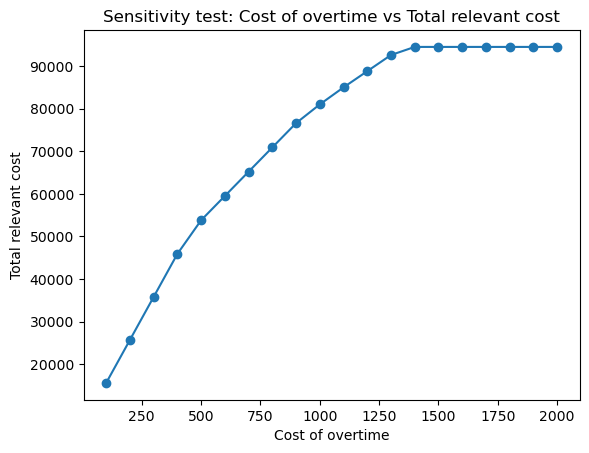

In [34]:
plt.plot(output['Cost of overtime u'], output['Total relevant cost'], marker='o')

plt.title('Sensitivity test: Cost of overtime vs Total relevant cost')
plt.xlabel('Cost of overtime')
plt.ylabel('Total relevant cost')